# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/train",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/valid",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3566 files belonging to 2 classes.
==========================Validation Data====================
Found 891 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Peach/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Peach/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3566 images belonging to 2 classes.
Found 891 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 31 12:17:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0               40W /  N/A|   4458MiB /  6144MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_DIY_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.9002
Epoch 1: val_accuracy improved from -inf to 0.96521, saving model to Peach_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 29s 148ms/step - loss: 0.2676 - accuracy: 0.9002 - val_loss: 0.1061 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9613
Epoch 2: val_accuracy did not improve from 0.96521
179/179 [==============================] - 25s 139ms/step - loss: 0.1213 - accuracy: 0.9613 - val_loss: 0.1337 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9661
Epoch 3: val_accuracy improved from 0.96521 to 0.97082, saving model to Peach_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 26s 144ms/step - loss: 0.1007 - accuracy: 0.9661 - val_loss: 0.0836 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9672
Epoch 4: val_accuracy improved from 0.97082 to 0.97306, saving model to Peach_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 25s 140ms/step - loss: 0.0879 - accuracy: 0.9672 - val_loss: 0.1050 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9714
Epoch 5: val_accuracy improved from 0.97306 to 0.98653, saving model to Peach_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 25s 141ms/step - loss: 0.0866 - accuracy: 0.9714 - val_loss: 0.0674 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9745
Epoch 6: val_accuracy did not improve from 0.98653
179/179 [==============================] - 25s 139ms/step - loss: 0.0791 - accuracy: 0.9745 - val_loss: 0.0550 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9787
Epoch 7: val_accuracy did not improve from 0.98653
179/179 [==============================] - 25s 139ms/step - loss: 0.0651 - accuracy: 0.9787 - val_loss: 0.1150 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 8/100
179/179 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9818
Epoch 8: val_accuracy improved from 0.98653 to 0.98878, saving model to Peach_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 26s 147ms/step - loss: 0.0580 - accuracy: 0.9818 - val_loss: 0.0348 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9725
Epoch 9: val_accuracy did not improve from 0.98878
179/179 [==============================] - 25s 139ms/step - loss: 0.0775 - accuracy: 0.9725 - val_loss: 0.0750 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9736
Epoch 10: val_accuracy did not improve from 0.98878
179/179 [==============================] - 26s 145ms/step - loss: 0.0817 - accuracy: 0.9736 - val_loss: 0.0930 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9619
Epoch 11: val_accuracy did not improve from 0.98878
179/179 [==============================] - 40s 224ms/step - loss: 0.1182 - accuracy: 0.9619 - val_loss: 0.2539 

INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 27s 150ms/step - loss: 0.0433 - accuracy: 0.9851 - val_loss: 0.0362 - val_accuracy: 0.9910 - lr: 1.0000e-04
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9846
Epoch 16: val_accuracy did not improve from 0.99102
179/179 [==============================] - 26s 147ms/step - loss: 0.0423 - accuracy: 0.9846 - val_loss: 0.0392 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 17/100
179/179 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9857
Epoch 17: val_accuracy did not improve from 0.99102
179/179 [==============================] - 28s 158ms/step - loss: 0.0352 - accuracy: 0.9857 - val_loss: 0.0293 - val_accuracy: 0.9910 - lr: 1.0000e-04
Epoch 18/100
179/179 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9888
Epoch 18: val_accuracy improved from 0.99102 to 0.99439, saving model to Peach_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model1_Based_Augmented\assets


179/179 [==============================] - 29s 161ms/step - loss: 0.0285 - accuracy: 0.9888 - val_loss: 0.0334 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 19/100
179/179 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9899
Epoch 19: val_accuracy did not improve from 0.99439
179/179 [==============================] - 27s 153ms/step - loss: 0.0241 - accuracy: 0.9899 - val_loss: 0.0373 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 20/100
179/179 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9877
Epoch 20: val_accuracy did not improve from 0.99439
179/179 [==============================] - 38s 212ms/step - loss: 0.0309 - accuracy: 0.9877 - val_loss: 0.0316 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 21/100
179/179 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9913
Epoch 21: val_accuracy did not improve from 0.99439
179/179 [==============================] - 33s 182ms/step - loss: 0.0258 - accuracy: 0.9913 - val

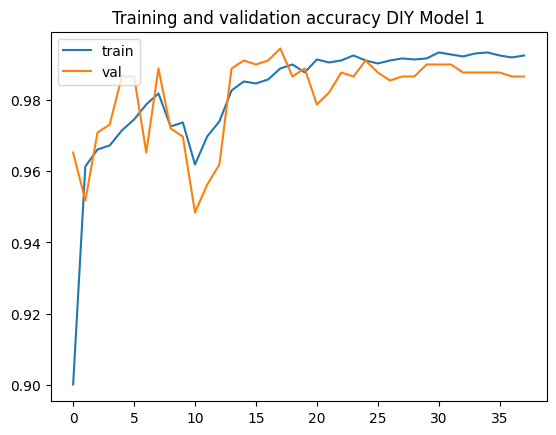

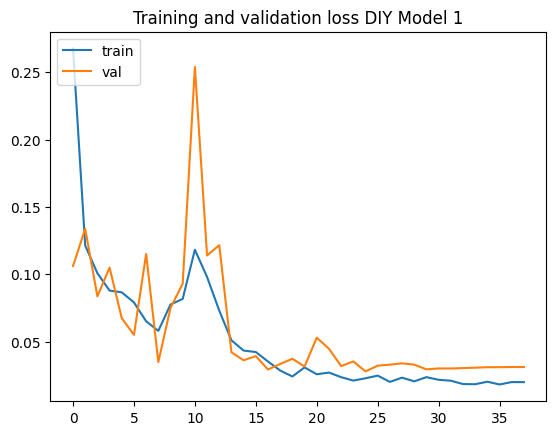

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_DIY_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.9019
Epoch 1: val_accuracy improved from -inf to 0.94613, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 29s 157ms/step - loss: 0.2851 - accuracy: 0.9019 - val_loss: 0.2616 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9568
Epoch 2: val_accuracy did not improve from 0.94613
179/179 [==============================] - 24s 136ms/step - loss: 0.1340 - accuracy: 0.9568 - val_loss: 0.2468 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9613
Epoch 3: val_accuracy improved from 0.94613 to 0.97194, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 28s 155ms/step - loss: 0.1156 - accuracy: 0.9613 - val_loss: 0.0926 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9658
Epoch 4: val_accuracy improved from 0.97194 to 0.97755, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 27s 153ms/step - loss: 0.0965 - accuracy: 0.9658 - val_loss: 0.0809 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9692
Epoch 5: val_accuracy improved from 0.97755 to 0.98204, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 29s 163ms/step - loss: 0.1025 - accuracy: 0.9692 - val_loss: 0.0604 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9644
Epoch 6: val_accuracy did not improve from 0.98204
179/179 [==============================] - 25s 137ms/step - loss: 0.1043 - accuracy: 0.9644 - val_loss: 0.0911 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9717
Epoch 7: val_accuracy improved from 0.98204 to 0.98541, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 29s 164ms/step - loss: 0.0779 - accuracy: 0.9717 - val_loss: 0.0617 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 8/100
179/179 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9734
Epoch 8: val_accuracy did not improve from 0.98541
179/179 [==============================] - 25s 137ms/step - loss: 0.0768 - accuracy: 0.9734 - val_loss: 0.1245 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9809
Epoch 9: val_accuracy did not improve from 0.98541
179/179 [==============================] - 25s 137ms/step - loss: 0.0536 - accuracy: 0.9809 - val_loss: 0.0571 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9804
Epoch 10: val_accuracy did not improve from 0.98541
179/179 [==============================] - 24s 136ms/step - loss: 0.0590 - accuracy: 0.9804 - val_loss: 0.0558 - 

INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 30s 169ms/step - loss: 0.0651 - accuracy: 0.9773 - val_loss: 0.0493 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 14/100
179/179 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9787
Epoch 14: val_accuracy improved from 0.98878 to 0.99327, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 31s 172ms/step - loss: 0.0527 - accuracy: 0.9787 - val_loss: 0.0318 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 15/100
179/179 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9801
Epoch 15: val_accuracy did not improve from 0.99327
179/179 [==============================] - 25s 138ms/step - loss: 0.0572 - accuracy: 0.9801 - val_loss: 0.0625 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9821
Epoch 16: val_accuracy did not improve from 0.99327
179/179 [==============================] - 25s 139ms/step - loss: 0.0461 - accuracy: 0.9821 - val_loss: 0.0363 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 17/100
179/179 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9798
Epoch 17: val_accuracy did not improve from 0.99327
179/179 [==============================] - 25s 140ms/step - loss: 0.0651 - accuracy: 0.9798 - val_loss: 0.077

INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 33s 186ms/step - loss: 0.0187 - accuracy: 0.9933 - val_loss: 0.0251 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 25/100
179/179 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9938
Epoch 25: val_accuracy improved from 0.99439 to 0.99551, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 34s 191ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0204 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 26/100
179/179 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9961
Epoch 26: val_accuracy did not improve from 0.99551
179/179 [==============================] - 26s 143ms/step - loss: 0.0147 - accuracy: 0.9961 - val_loss: 0.0221 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 27/100
179/179 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9941
Epoch 27: val_accuracy improved from 0.99551 to 0.99663, saving model to Peach_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 34s 190ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0206 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 28/100
179/179 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9947
Epoch 28: val_accuracy did not improve from 0.99663
179/179 [==============================] - 25s 142ms/step - loss: 0.0166 - accuracy: 0.9947 - val_loss: 0.0253 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 29/100
179/179 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9938
Epoch 29: val_accuracy did not improve from 0.99663
179/179 [==============================] - 25s 138ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0214 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 30/100
179/179 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9947
Epoch 30: val_accuracy did not improve from 0.99663

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
179/179 [=========

INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_DIY_model2_Based_Augmented\assets


179/179 [==============================] - 33s 183ms/step - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0215 - val_accuracy: 0.9978 - lr: 1.0000e-05
Epoch 32/100
179/179 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9952
Epoch 32: val_accuracy did not improve from 0.99776
179/179 [==============================] - 24s 136ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0214 - val_accuracy: 0.9955 - lr: 1.0000e-05
Epoch 33/100
179/179 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9958
Epoch 33: val_accuracy did not improve from 0.99776
179/179 [==============================] - 24s 136ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0228 - val_accuracy: 0.9944 - lr: 1.0000e-05
Epoch 34/100
179/179 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9952
Epoch 34: val_accuracy did not improve from 0.99776
179/179 [==============================] - 25s 137ms/step - loss: 0.0141 - accuracy: 0.9952 - val

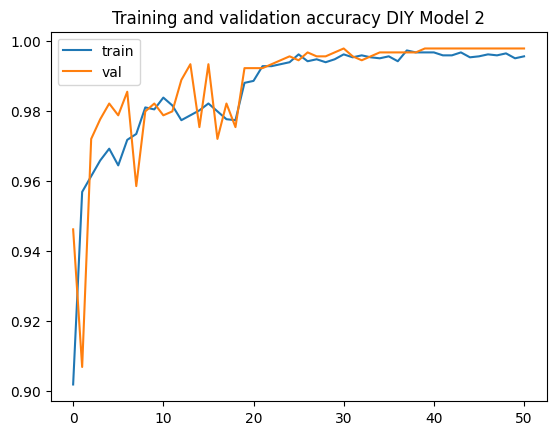

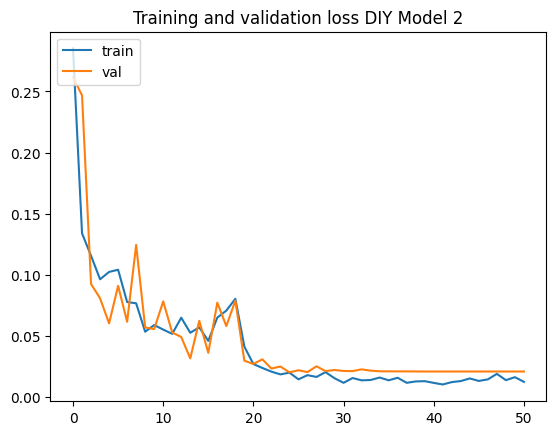

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')